## import hubs and cell scores

In [54]:
import pandas as pd
import numpy as np
import pickle
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import spatial
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
import os

from scipy import stats

from matplotlib.pyplot import rc_context

import gseapy as gp



with open('../data/files/R1_TMS_HUBS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    hubs = pickle.load(handle)
    
hub_metadata = pd.read_pickle('../data/files/R1_TMS_HUBS_METADATA_FILTERED.pickle')


with open('../data/gene_lists/mouse_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist() #FIX MOUSE
senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo

gene_set = {'senescence':list(markers)} #for enrichr

hubs_enr = {k[0] + ' ' + k[1] + ' ' + str(k[2]): [x[0] for x in v] for (k,v) in hubs.items()} #for enrichr

In [23]:
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data_BDATA.h5ad')

In [24]:
df = pd.read_pickle('../data/files/R1_7_TMS_HUB_SCORES_FILTERED_v1.pickle')
adata.obsm['hub_scores'] = df

tissue_cells = adata.obs.groupby(['tissue2', 'cell_type_2']).size().reset_index().rename(columns={0:'Count'})
tissue_cells = tissue_cells[tissue_cells.Count > 0]


In [25]:
def find_outliers(scores, mult = 3):
    sd = scores.std()
    mu = scores.mean()
    
    thresh = mu + mult*sd
    
    return scores > thresh
    
    
big_out = []

#may want to add filter so that x number of cells in aged organism exists, or can just filter later...
for tissue, cell in tqdm(tissue_cells[tissue_cells.columns[0:2]].values):
    #print(tissue, cell)

    sub = adata[(adata.obs.tissue2 == tissue) & (adata.obs.cell_type_2 == cell)]
    #sub.obs = pd.concat((sub.obs,sub.obsm['hub_scores']), axis = 1) #recombine just to make easier to filter/plot etc

    out = []
    for hub in sub.obsm['hub_scores'].columns:

        #sd = sub.obsm['hub_scores'][hub].std()
        #mu = sub.obsm['hub_scores'][hub].mean()

        out.append(find_outliers(sub.obsm['hub_scores'][hub]))

      
    big_out.append(pd.concat(out, axis = 1))    


100%|█████████████████████████████████████████| 138/138 [00:10<00:00, 12.67it/s]


In [28]:
adata.obsm['sen_outlier'] = pd.concat(big_out).reindex(adata.obs.index)
adata.obsm['sen_outlier']

,Bladder__bladder cell__0,Bladder__bladder cell__1,Bladder__bladder cell__2,Bladder__endothelial cell__3,Brain__microglial cell__1,Brain__microglial cell__2,Diaphragm__mesenchymal stem cell__0,Diaphragm__skeletal muscle satellite cell__0,Diaphragm__skeletal muscle satellite cell__1,Fat__endothelial cell__0,...,Tongue__basal cell __0,Tongue__basal cell __1,Tongue__keratinocyte__0,Tongue__keratinocyte__1,Trachea__basal cell __0,Trachea__basal cell __2,Trachea__fibroblast__0,Trachea__fibroblast__1,Trachea__macrophage__0,Trachea__macrophage__1
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACCTGCAGTAAGCG-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACCTGTCATTATCC-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACGGGGTACAGTGG-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACGGGGTCTTCTCG-1-0-0-0-0-0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P9.MAA001883.3_39_F.1.1-1-1-1-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
P9.MAA001887.3_39_F.1.1-1-1-1-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# kinetics/characterstics of multi-hub examples

## toungue keratinocyte

In [30]:
hub_metadata[(hub_metadata.tissue == 'Tongue') & (hub_metadata.cell == 'keratinocyte')]

,tissue,cell,hub_num,size,n_sen,hyp
64,Tongue,keratinocyte,0,197,5,3.504157e-02
65,Tongue,keratinocyte,1,350,16,1.499907e-07


In [31]:
sdata = adata[(adata.obs.cell_type_2 == 'keratinocyte') & (adata.obs.tissue2 == 'Tongue')]

In [32]:
sdata.obs['Tongue__keratinocyte__0'] = sdata.obsm['sen_outlier']['Tongue__keratinocyte__0']*1
sdata.obs['Tongue__keratinocyte__1'] = sdata.obsm['sen_outlier']['Tongue__keratinocyte__1']*1


sdata.obs['Tongue__keratinocyte__0_s'] = sdata.obsm['hub_scores']['Tongue__keratinocyte__0']
sdata.obs['Tongue__keratinocyte__1_s'] = sdata.obsm['hub_scores']['Tongue__keratinocyte__1']

/tmp/ipykernel_3630448/706448531.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata.obs['Tongue__keratinocyte__0'] = sdata.obsm['sen_outlier']['Tongue__keratinocyte__0']*1


In [33]:
df = sdata.obs[['age', 'Tongue__keratinocyte__0',
           'Tongue__keratinocyte__1']].groupby('age').sum()
df

,Tongue__keratinocyte__0,Tongue__keratinocyte__1
age,,
1m,48,0
3m,10,8
18m,13,4
24m,247,168


In [34]:
sdata.obs.groupby('age').count().batch #make sure index in same order

age
1m     2711
3m     3884
18m    2118
24m    3622
Name: batch, dtype: int64

In [35]:
df['Count'] = sdata.obs.groupby('age').count().batch #make sure index in same order

In [36]:
df['hub 0'] = df.Tongue__keratinocyte__0 / df.Count * 100
df['hub 1'] = df.Tongue__keratinocyte__1 / df.Count * 100

In [37]:
df

,Tongue__keratinocyte__0,Tongue__keratinocyte__1,Count,hub 0,hub 1
age,,,,,
1m,48,0,2711,1.770564,0.000000
3m,10,8,3884,0.257467,0.205973
18m,13,4,2118,0.613787,0.188857
24m,247,168,3622,6.819437,4.638321


In [38]:
df2 = sdata.obs.melt(id_vars = 'age', value_vars = ['Tongue__keratinocyte__0_s', 'Tongue__keratinocyte__1_s'])
df2

,age,variable,value
0,24m,Tongue__keratinocyte__0_s,0.236954
1,24m,Tongue__keratinocyte__0_s,0.821293
2,24m,Tongue__keratinocyte__0_s,-0.184298
3,24m,Tongue__keratinocyte__0_s,0.804246
4,24m,Tongue__keratinocyte__0_s,2.395585
...,...,...,...
24665,3m,Tongue__keratinocyte__1_s,21.852841
24666,3m,Tongue__keratinocyte__1_s,24.915078
24667,3m,Tongue__keratinocyte__1_s,22.624293
24668,3m,Tongue__keratinocyte__1_s,11.562643


In [39]:
df['age'] = df.index
df

,Tongue__keratinocyte__0,Tongue__keratinocyte__1,Count,hub 0,hub 1,age
age,,,,,,
1m,48,0,2711,1.770564,0.000000,1m
3m,10,8,3884,0.257467,0.205973,3m
18m,13,4,2118,0.613787,0.188857,18m
24m,247,168,3622,6.819437,4.638321,24m


In [40]:
df = df.melt(id_vars = 'age', value_vars=['hub 0', 'hub 1'])
df

,age,variable,value
0,1m,hub 0,1.770564
1,3m,hub 0,0.257467
2,18m,hub 0,0.613787
3,24m,hub 0,6.819437
4,1m,hub 1,0.000000
5,3m,hub 1,0.205973
6,18m,hub 1,0.188857
7,24m,hub 1,4.638321


In [41]:
df.age = df.age.map(lambda x: int(x.replace('m', ''))).astype('int')

In [18]:
#df2.age = df2.age.map(lambda x: int(x.replace('m', ''))).astype('int')

### Fig 3F

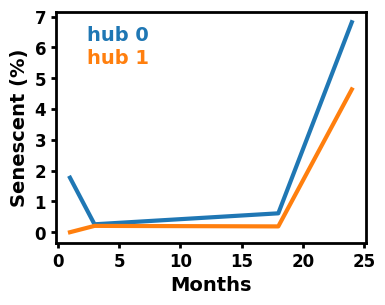

In [19]:
plt.figure(figsize = (4,3))

ax = sns.lineplot(data = df, x = 'age', y = 'value', hue = 'variable', lw = 3)


for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2)
    
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.xticks(size = 12,  weight = 'bold')
plt.yticks(size = 12, weight = 'bold')

ax.tick_params(width = 2)

plt.ylabel('Senescent (%)', size = 14, weight = 'bold')

plt.xlabel('Months', size = 14, weight = 'bold')

plt.legend([],[], frameon=False)

plt.text(s = 'hub 0', x = 0.1, y = 0.9, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:blue')

plt.text(s = 'hub 1', x = 0.1, y = 0.8, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:orange')


plt.savefig('figures/R1_3F.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_3F.svg', bbox_inches = 'tight')

plt.show()

### Fig 3E

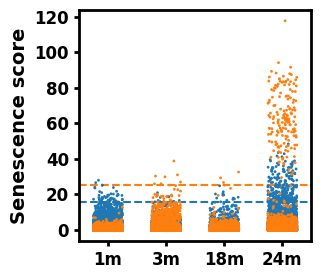

In [20]:
plt.figure(figsize = (3,3))


ax = sns.stripplot(data = df2, x = 'age', y = 'value', hue = 'variable',
              s = 2, jitter = .25)

plt.legend([],[], frameon=False)



ax.axhline(df2[df2.variable == 'Tongue__keratinocyte__0_s'].value.mean() +\
            3*df2[df2.variable == 'Tongue__keratinocyte__0_s'].value.std(),
           c = 'tab:blue', zorder = 0, ls = '--', lw = 1.5)


ax.axhline(df2[df2.variable == 'Tongue__keratinocyte__1_s'].value.mean() +\
            3*df2[df2.variable == 'Tongue__keratinocyte__1_s'].value.std(), 
          c = 'tab:orange', zorder = 0, ls = '--', lw = 1.5)




for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2)
    
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.xticks(size = 12,  weight = 'bold' ) #rotation = 35, rotation_mode = 'anchor', ha = 'right'
plt.yticks(size = 12, weight = 'bold')

ax.tick_params(width = 2)

plt.ylabel('Senescence score', size = 14, weight = 'bold')

plt.xlabel('')

plt.savefig('figures/R1_3E.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_3E.svg', bbox_inches = 'tight')


plt.show()

In [21]:
df2

,age,variable,value
0,24m,Tongue__keratinocyte__0_s,0.236954
1,24m,Tongue__keratinocyte__0_s,0.821293
2,24m,Tongue__keratinocyte__0_s,-0.184298
3,24m,Tongue__keratinocyte__0_s,0.804246
4,24m,Tongue__keratinocyte__0_s,2.395585
...,...,...,...
24665,3m,Tongue__keratinocyte__1_s,21.852841
24666,3m,Tongue__keratinocyte__1_s,24.915078
24667,3m,Tongue__keratinocyte__1_s,22.624293
24668,3m,Tongue__keratinocyte__1_s,11.562643


In [42]:
thresh_0 = df2[df2.variable == 'Tongue__keratinocyte__0_s'].value.mean() +\
            3*df2[df2.variable == 'Tongue__keratinocyte__0_s'].value.std()

In [43]:
thresh_1 = df2[df2.variable == 'Tongue__keratinocyte__1_s'].value.mean() +\
            3*df2[df2.variable == 'Tongue__keratinocyte__1_s'].value.std()

In [44]:
sub = df2[df2.variable == 'Tongue__keratinocyte__0_s']


m1 = sub[sub.age == '1m'].value.values
m2 = sub[sub.age == '3m'].value.values
m3 = sub[sub.age == '18m'].value.values
m4 = sub[sub.age == '24m'].value.values

m1b = [1 if x > thresh_0 else 0 for x in m1]
m2b = [1 if x > thresh_0 else 0 for x in m2]
m3b = [1 if x > thresh_0 else 0 for x in m3]
m4b = [1 if x > thresh_0 else 0 for x in m4]

contingency_table = np.array([
    [m1b.count(1), m1b.count(0)],
    [m2b.count(1), m2b.count(0)],
    [m3b.count(1), m3b.count(0)],
    [m4b.count(1), m4b.count(0)]
])

chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(p_value)

1.5229141479149834e-82


In [45]:
sub = df2[df2.variable == 'Tongue__keratinocyte__1_s']


m1 = sub[sub.age == '1m'].value.values
m2 = sub[sub.age == '3m'].value.values
m3 = sub[sub.age == '18m'].value.values
m4 = sub[sub.age == '24m'].value.values

m1b = [1 if x > thresh_0 else 0 for x in m1]
m2b = [1 if x > thresh_0 else 0 for x in m2]
m3b = [1 if x > thresh_0 else 0 for x in m3]
m4b = [1 if x > thresh_0 else 0 for x in m4]

contingency_table = np.array([
    [m1b.count(1), m1b.count(0)],
    [m2b.count(1), m2b.count(0)],
    [m3b.count(1), m3b.count(0)],
    [m4b.count(1), m4b.count(0)]
])

chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(p_value)

6.210870174938935e-66


In [30]:


#m1 = [1 if x > threshold else 0 for x in activity_1pm]

In [46]:


h_statistic, p_value = stats.kruskal(m1, m2, m3, m4)

In [47]:
p_value

1.0371623383947107e-161

In [75]:
test = hubs[('Tongue','keratinocyte',0)]
test = [x[0] for x in test]

enr = gp.enrichr(gene_list= test,
             gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2021', hubs_enr, gene_set],
             organism='mouse', # don't forget to set organism to the one you desired!
             outdir=None, # don't write to disk,
             background = adata.var_names.tolist()
            )

res1 = enr.results
res1['hub'] = 0

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/gseapy/enrichr.py:556: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr


In [76]:
test = hubs[('Tongue','keratinocyte',1)]
test = [x[0] for x in test]

enr = gp.enrichr(gene_list= test,
             gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2021', hubs_enr, gene_set],
             organism='mouse', # don't forget to set organism to the one you desired!
             outdir=None, # don't write to disk,
             background = adata.var_names.tolist()
            )

res = enr.results
res['hub'] = 1

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/gseapy/enrichr.py:556: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr


In [77]:
res = pd.concat((res1, res))

In [43]:
#len(res.loc[968].Genes.split(';'))

In [78]:
res = res[res['Adjusted P-value'] < 0.05]

res['nlog10'] = -np.log10(res['Adjusted P-value'])

res['num'] = res.Genes.map(lambda x: len(x.split(';')))

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


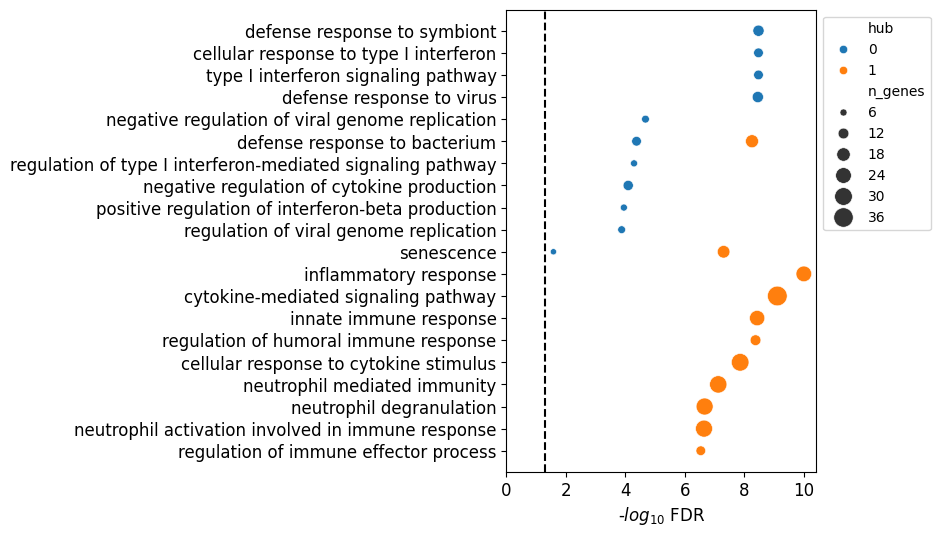

In [55]:
go10 = pd.concat((res[(res.hub == 0) &\
                      (res.Gene_set.str.startswith('GO'))].nsmallest(n = 10, columns = 'Adjusted P-value'), 
                 res[(res.hub == 1) &\
                      (res.Gene_set.str.startswith('GO'))].nsmallest(n = 10, columns = 'Adjusted P-value')))

go10['Term'] = go10['Term'].map(lambda x: x.split(' (')[0])

go10 = pd.concat((go10, res[res.Term == 'senescence']))

go10 = go10.sort_values(['hub', 'nlog10'], ascending = [True, False])


go10 = go10.rename(columns = {'num': 'n_genes'})


plt.figure(figsize = (4,6))
sns.scatterplot(data = go10, y = 'Term', x = 'nlog10', hue = 'hub', size= 'n_genes' , sizes = (20,200))

plt.yticks(size = 12)

plt.xticks(size = 12)

plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.xlabel("-$log_{10}$ FDR", size = 12)

plt.savefig('figures/R1_3B.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_3B.svg', bbox_inches = 'tight')

plt.show()

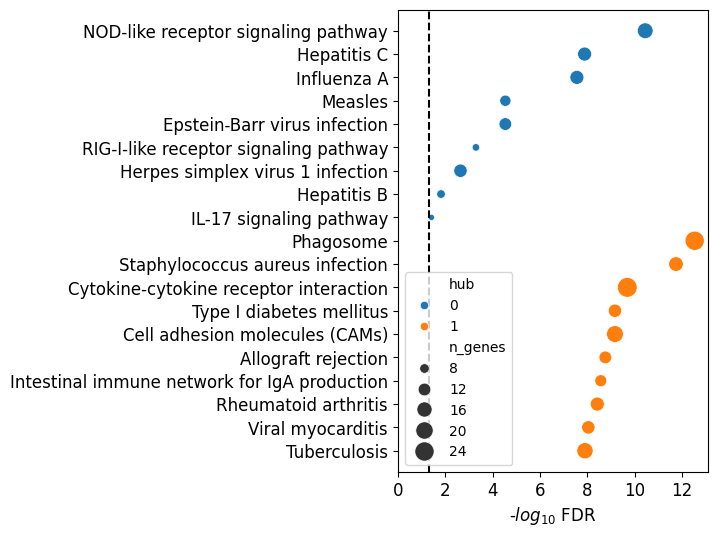

In [58]:
go10 = pd.concat((res[(res.hub == 0) &\
                      (res.Gene_set.str.startswith('KEGG'))].nsmallest(n = 10, columns = 'Adjusted P-value'), 
                 res[(res.hub == 1) &\
                      (res.Gene_set.str.startswith('KEGG'))].nsmallest(n = 10, columns = 'Adjusted P-value')))


plt.figure(figsize = (4,6))

go10 = go10.rename(columns = {'num': 'n_genes'})

sns.scatterplot(data = go10, y = 'Term', x = 'nlog10', hue = 'hub', size= 'n_genes' , sizes = (20,200))

plt.yticks(size = 12)

plt.xticks(size = 12)

plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')

plt.legend(loc='lower left')


plt.xlabel("-$log_{10}$ FDR", size = 12)

plt.savefig('figures/R1_3C.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_3C.svg', bbox_inches = 'tight')


plt.show()

In [80]:
go10

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes,Overlap,hub,nlog10,num
0,KEGG_2019_Mouse,NOD-like receptor signaling pathway,2.086321e-13,3.567609e-11,0.0,0.0,13.537721,395.277153,RNASEL;GBP7;IFI204;STAT2;OAS1A;OAS1B;TNF;OAS1G...,NaN,0,10.447623,17
1,KEGG_2019_Mouse,Hepatitis C,1.515990e-10,1.296172e-08,0.0,0.0,11.645481,263.301793,RNASEL;RSAD2;DDX58;MX2;STAT2;OAS1A;OAS1B;CLDN2...,NaN,0,7.887337,14
2,KEGG_2019_Mouse,Influenza A,4.810628e-10,2.742058e-08,0.0,0.0,10.579846,226.990850,RNASEL;RSAD2;DDX58;MX2;STAT2;OAS1A;OAS1B;TNF;O...,NaN,0,7.561923,14
3,KEGG_2019_Mouse,Measles,7.152988e-07,2.879986e-05,0.0,0.0,8.677566,122.792472,IFIH1;DDX58;OAS2;OAS3;MX2;STAT2;IRF7;OAS1A;OAS...,NaN,0,4.540610,10
4,KEGG_2019_Mouse,Epstein-Barr virus infection,8.421013e-07,2.879986e-05,0.0,0.0,6.664527,93.219176,MAPK11;H2-T10;H2-Q8;DDX58;OAS2;STAT2;OAS3;IRF7...,NaN,0,4.540610,12
5,KEGG_2019_Mouse,RIG-I-like receptor signaling pathway,1.766049e-05,5.033240e-04,0.0,0.0,12.483141,136.617754,IFIH1;MAPK11;DDX58;DHX58;IRF7;TNF,NaN,0,3.298152,6
6,KEGG_2019_Mouse,Herpes simplex virus 1 infection,9.270452e-05,2.264639e-03,0.0,0.0,3.795613,35.246420,RNASEL;H2-T10;H2-Q8;DDX58;STAT2;OAS1A;OAS1B;TN...,NaN,0,2.645001,13
7,KEGG_2019_Mouse,Hepatitis B,7.025405e-04,1.501680e-02,0.0,0.0,5.095031,36.994041,IFIH1;MAPK11;CASP12;DDX58;STAT2;IRF7;TNF,NaN,0,1.823423,7
8,KEGG_2019_Mouse,IL-17 signaling pathway,2.015129e-03,3.828744e-02,0.0,0.0,6.005632,37.277393,MAPK11;CSF3;TNF;S100A9;CXCL5,NaN,0,1.416944,5
0,KEGG_2019_Mouse,Phagosome,1.546863e-15,2.908103e-13,0.0,0.0,10.174026,346.960194,H2-EB1;C1RA;H2-DMA;H2-Q6;CD209F;NCF4;H2-M3;ITG...,NaN,1,12.536390,24


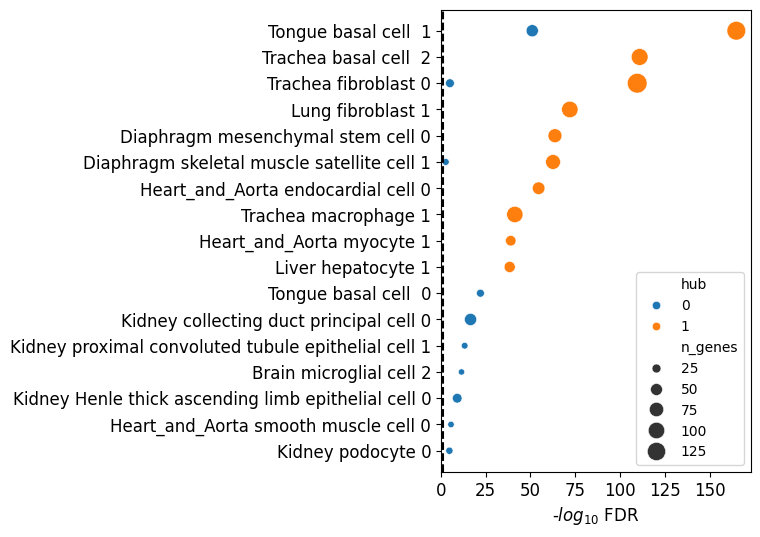

In [59]:
def remove_self_comparisons(x): #pass overlap, none are the same exact genes
    left, right = x.split('/')
    if left == right:
        return False
    else:
        return True


plotter = res[res.Gene_set.str.contains('gs_ind')]

plotter = plotter[plotter.Overlap.map(remove_self_comparisons)]

plotter = plotter[plotter['Adjusted P-value'] < 0.05]
plotter = plotter[plotter.Term != 'senescence']

plotter = pd.concat((plotter[(plotter.hub == 0)].nsmallest(n = 10, columns = 'Adjusted P-value'), 
                 plotter[(plotter.hub == 1)].nsmallest(n = 10, columns = 'Adjusted P-value')))


plotter = plotter.sort_values('Adjusted P-value')
plotter = plotter.rename(columns = {'num': 'n_genes'})



plt.figure(figsize = (4,6))
sns.scatterplot(data = plotter, y = 'Term', x = 'nlog10', hue = 'hub', size= 'n_genes' , sizes = (20,200))

plt.yticks(size = 12)

plt.xticks(size = 12)

plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')

plt.xlabel("-$log_{10}$ FDR", size = 12)

plt.savefig('figures/R1_3D.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_3D.svg', bbox_inches = 'tight')

plt.show()

## Fibroblast

In [48]:
meta_sub = hub_metadata[(hub_metadata.cell == 'fibroblast')]
meta_sub.reset_index(drop = True)

,tissue,cell,hub_num,size,n_sen,hyp
0,Heart_and_Aorta,fibroblast,0,80,5,8.372629e-04
1,Heart_and_Aorta,fibroblast,1,50,2,7.663093e-02
2,Lung,fibroblast,0,244,2,6.562770e-01
3,Lung,fibroblast,1,552,21,3.756258e-08
4,Trachea,fibroblast,0,808,27,5.751673e-09
5,Trachea,fibroblast,1,102,2,2.394198e-01


In [49]:
sdata = adata[(adata.obs.cell_type_2 == 'fibroblast') &
              (adata.obs.tissue2.isin(['Heart_and_Aorta', 'Lung', 'Trachea']))]


In [50]:
out = []
for y in range(len(meta_sub)):
    for age in ['1m', '3m', '18m', '21m', '24m', '30m']:
        
        tissue = meta_sub.iloc[y].tissue
        hub_num = meta_sub.iloc[y].hub_num
        
        
        subby = sdata[(sdata.obs.tissue2 == tissue) & (sdata.obs.age == age)]
        
        num_outliers = subby.obsm['sen_outlier'][tissue + '__fibroblast__' + str(hub_num)].sum()
        
        out.append([tissue, hub_num, age, len(subby), num_outliers])
        

In [51]:
df = pd.DataFrame(out, columns = ['tissue', 'hub', 'age', 'Count', 'value'])
df = df[df.Count > 75]
df['per'] = df.value /df.Count * 100

df.age = df.age.map(lambda x: int(x.replace('m', '')))

df

,tissue,hub,age,Count,value,per
0,Heart_and_Aorta,0,1,266,2,0.751880
1,Heart_and_Aorta,0,3,2419,16,0.661430
2,Heart_and_Aorta,0,18,1332,10,0.750751
3,Heart_and_Aorta,0,21,294,0,0.000000
4,Heart_and_Aorta,0,24,1063,66,6.208843
5,Heart_and_Aorta,0,30,1005,27,2.686567
6,Heart_and_Aorta,1,1,266,3,1.127820
7,Heart_and_Aorta,1,3,2419,15,0.620091
8,Heart_and_Aorta,1,18,1332,32,2.402402
9,Heart_and_Aorta,1,21,294,1,0.340136


In [52]:
#group these not on 1 and 0, but similarity?

In [55]:
fibos = {k:v for (k,v) in hubs.items() if k[0] in ['Heart_and_Aorta', 'Lung', 'Trachea'] and k[1] == 'fibroblast'}

#combos = list(itertools.combinations(list(fibos), 2))
combos = list(itertools.product(list(fibos), list(fibos))) #includes self comparison

In [56]:
#calculate "importance" of each gene to signature by the number of edges, normalize by total nodes

out = []
for combo in tqdm(combos):
    test1 = hubs[combo[0]]
    test2 = hubs[combo[1]]
    test1 = pd.DataFrame(test1)
    test1[1] = test1[1]/len(test1)
    test2 = pd.DataFrame(test2)
    test2[1] = test2[1]/len(test2)
    vals = test1.merge(right = test2, left_on = 0,  right_on = 0, how = 'outer')
    vals = vals.fillna(0)
    #result =1 - spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
    result = spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
    out.append([combo[0][0] + '__'  + str(combo[0][2]),
                combo[1][0] + '__' + str(combo[1][2]), result])

100%|██████████████████████████████████████████| 36/36 [00:00<00:00, 481.48it/s]


In [57]:
dists = pd.DataFrame(out, columns = ['h1', 'h2', 'distance'])
dists

,h1,h2,distance
0,Heart_and_Aorta__0,Heart_and_Aorta__0,0.000000
1,Heart_and_Aorta__0,Heart_and_Aorta__1,1.000000
2,Heart_and_Aorta__0,Lung__0,0.973290
3,Heart_and_Aorta__0,Lung__1,0.881140
4,Heart_and_Aorta__0,Trachea__0,0.878699
5,Heart_and_Aorta__0,Trachea__1,0.960674
6,Heart_and_Aorta__1,Heart_and_Aorta__0,1.000000
7,Heart_and_Aorta__1,Heart_and_Aorta__1,0.000000
8,Heart_and_Aorta__1,Lung__0,1.000000
9,Heart_and_Aorta__1,Lung__1,0.970603


In [58]:
dists = dists.pivot(columns='h2', index = 'h1', values='distance')
dists.index.name = None

#dists[dists == 1] = 0.95
dists

h2,Heart_and_Aorta__0,Heart_and_Aorta__1,Lung__0,Lung__1,Trachea__0,Trachea__1
Heart_and_Aorta__0,0.000000,1.000000,0.973290,0.881140,0.878699,0.960674
Heart_and_Aorta__1,1.000000,0.000000,1.000000,0.970603,0.999427,0.958907
Lung__0,0.973290,1.000000,0.000000,1.000000,0.862100,0.997613
Lung__1,0.881140,0.970603,1.000000,0.000000,0.470515,0.991649
Trachea__0,0.878699,0.999427,0.862100,0.470515,0.000000,1.000000
Trachea__1,0.960674,0.958907,0.997613,0.991649,1.000000,0.000000


In [59]:
condensed = []
for x, row in enumerate(dists.iterrows()):
    vals = row[1].tolist()
    condensed += vals[x+1:]

In [60]:
linkage_data = linkage(condensed)

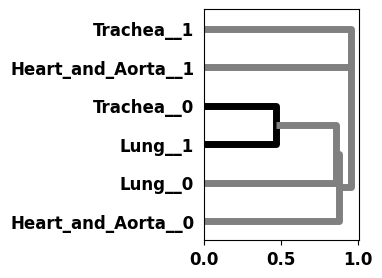

In [61]:
hierarchy.set_link_color_palette(['k', 'y'])

with rc_context({'lines.linewidth': 5}):


    plt.figure(figsize = (2,3))

    ax = dendrogram(linkage_data, orientation = 'right', labels = dists.columns,
                    above_threshold_color='grey')
    

    plt.xticks(size = 12,  weight = 'bold')
    plt.yticks(size = 12, weight = 'bold')


    #plt.savefig('figures/R1_3G.png', dpi = 600, bbox_inches = 'tight')
    #plt.savefig('figures/R1_3G.svg', bbox_inches = 'tight')

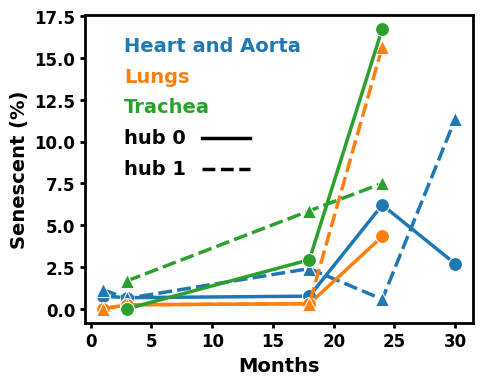

In [72]:
plt.figure(figsize = (5,4))


ax = sns.lineplot(data = df[df.age != 21], x = 'age', y = 'per', hue = 'tissue',
                  style='hub', markersize = 10, markers = ['o', '^'], lw = 2.5)



for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2)
    
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.xticks(size = 12,  weight = 'bold')
plt.yticks(size = 12, weight = 'bold')

ax.tick_params(width = 2)

plt.ylabel('Senescent (%)', size = 14, weight = 'bold')

plt.xlabel('Months', size = 14, weight = 'bold')

plt.legend([],[], frameon=False)

plt.text(s = 'Heart and Aorta', x = 0.1, y = 0.9, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:blue')

plt.text(s = 'Lungs', x = 0.1, y = 0.8, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:orange')

plt.text(s = 'Trachea', x = 0.1, y = 0.7, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold', c = 'tab:green')


plt.text(s = 'hub 0', x = 0.1, y = 0.6, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold')

plt.text(s = 'hub 1', x = 0.1, y = 0.5, ha = 'left', va = 'center', transform = ax.transAxes,
         size = 14, weight = 'bold')

plt.plot([.3, .425], [0.6, 0.6], transform = ax.transAxes, c = 'k', lw = 2.5)
plt.plot([.3, .425], [0.5, 0.5], transform = ax.transAxes, c = 'k', ls = '--', lw = 2.5)

plt.savefig('figures/R1_3H.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_3H.svg', bbox_inches = 'tight')

plt.show()

In [62]:

dfs_out = []

for hub in fibos:
    test = hubs[hub]
    test = [x[0] for x in test]
    
    
    enr = gp.enrichr(gene_list= [x for x in test if x != 'Kit'], #Kit throws an error for some reason...
             gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2021', hubs_enr, gene_set],
             organism='mouse', # don't forget to set organism to the one you desired!
             outdir=None, # don't write to disk,
             background = adata.var_names.tolist()
            )
    
    
    res = enr.results
    res['tissue'] = hub[0]
    res['hub'] = hub[2]
    dfs_out.append(res)
    

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/gseapy/enrichr.py:556: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/gseapy/enrichr.py:556: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/gseapy/enrichr.py:556: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr


In [63]:
fibo_go = pd.concat(dfs_out)

In [64]:
l = fibo_go[(fibo_go.tissue == 'Lung') & (fibo_go.hub == 1)]
l = l[l['Adjusted P-value'] < 0.05]

In [65]:
t = fibo_go[(fibo_go.tissue == 'Trachea') & (fibo_go.hub == 0)]
t = t[t['Adjusted P-value'] < 0.05]

### Fig 3I

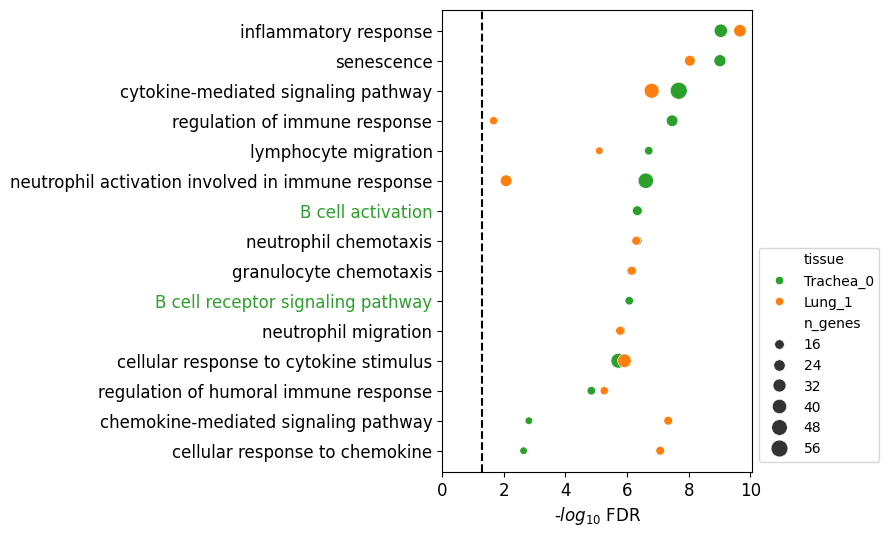

In [68]:
#get all terms in top 10 for both, include if in the other top 10
go10 = pd.concat((t,l))



go10 = go10[(go10.Gene_set.str.startswith('GO')) | (go10.Term == 'senescence')]

l_terms = go10[go10.tissue == 'Lung'].nsmallest(n = 10, columns = 'Adjusted P-value').Term.unique().tolist()
t_terms = go10[go10.tissue == 'Trachea'].nsmallest(n = 10, columns = 'Adjusted P-value').Term.unique().tolist()

go10_terms = l_terms + t_terms
go10_terms = list(set(go10_terms + ['senescence']))


go10 = go10[go10.Term.isin(go10_terms)]



go10.tissue = go10.tissue.map({'Trachea' : 'Trachea_0', 'Lung':'Lung_1'})


go10['nlog10'] = -np.log10(go10['Adjusted P-value'])
#go10['num'] = go10.Overlap.map(lambda x: int(x.split('/')[0]) )
go10['num'] = go10.Genes.map(lambda x: len(x.split(';')))
go10['Term_trim'] = go10.Term.map(lambda x: x.split(' (')[0])


go10 = go10.sort_values(['hub', 'nlog10'], ascending = [True, False])


go10 = go10.rename(columns = {'num': 'n_genes'})


plt.figure(figsize = (4,6))
ax = sns.scatterplot(data = go10, y = 'Term_trim', x = 'nlog10', hue = 'tissue', size = 'n_genes', sizes = (30,150),
                    palette = ['tab:green', 'tab:orange'])



plt.yticks(size = 12)

plt.xticks(size = 12)


plt.ylabel('')

plt.xlim(left = 0)

plt.axvline(-np.log10(0.05), ls = '--', c = 'k')


yticklabels = [t for t in ax.get_yticklabels()]

for y, term in enumerate(go10.Term_trim.unique().tolist()): #SHOULD be in the same order as axis, but be careful
    if len(go10[go10.Term_trim == term]) < 2:
        if go10[go10.Term_trim == term].iloc[0].tissue == 'Trachea_0':
            yticklabels[y].set_color('tab:green')
        else:
            yticklabels[y].set_color('tab:orange')
        
    else:
        yticklabels[y].set_color('k')


plt.xlabel("-$log_{10}$ FDR", size = 12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))



plt.savefig('figures/R1_3I.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_3I.svg', bbox_inches = 'tight')


plt.show()



In [81]:
#get all terms in top 10 for both, include if in the other top 10
# go10 = pd.concat((t,l))

# go10 = go10[(go10.Gene_set.str.startswith('KEGG')) | (go10.Term == 'sensecence')]

# l_terms = go10[go10.tissue == 'Lung'].nsmallest(n = 10, columns = 'Adjusted P-value').Term.unique().tolist()
# t_terms = go10[go10.tissue == 'Trachea'].nsmallest(n = 10, columns = 'Adjusted P-value').Term.unique().tolist()

# go10_terms = l_terms + t_terms
# go10_terms = list(set(go10_terms))


# go10 = go10[go10.Term.isin(go10_terms)]





# go10['nlog10'] = -np.log10(go10['Adjusted P-value'])
# go10['num'] = go10.Overlap.map(lambda x: int(x.split('/')[0]) )
# go10['Term_trim'] = go10.Term.map(lambda x: x.split(' (')[0])


# go10 = go10.sort_values(['hub', 'nlog10'], ascending = [True, False])

# plt.figure(figsize = (4,6))
# ax = sns.scatterplot(data = go10, y = 'Term_trim', x = 'nlog10', hue = 'tissue', size = 'num', sizes = (30,150))



# plt.yticks(size = 12)

# plt.xticks(size = 12)


# plt.ylabel('')

# plt.xlim(left = 0)

# plt.axvline(-np.log10(0.05), ls = '--', c = 'k')


# yticklabels = [t for t in ax.get_yticklabels()]

# for y, term in enumerate(go10.Term_trim.unique().tolist()): #SHOULD be in the same order as axis, but be careful
#     if len(go10[go10.Term_trim == term]) < 2:
#         if go10[go10.Term_trim == term].iloc[0].tissue == 'Trachea':
#             yticklabels[y].set_color('tab:blue')
#         else:
#             yticklabels[y].set_color('tab:orange')
        
#     else:
#         yticklabels[y].set_color('k')


# plt.show()


In [70]:
meta

NameError: name 'meta' is not defined

### Fig 3A

In [82]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import senepy as sp
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text


In [83]:
corr_path = '../data/files/tms_corr/'

corr_files = os.listdir('../data/files/tms_corr/')

corrs = pd.concat([pd.read_pickle(corr_path + x) for x in corr_files])
corrs['dif'] = corrs.r - corrs.rnd_r_q99
corrs_sig = corrs[(corrs.r > corrs.rnd_r_q99) & (corrs.r > 0) & (corrs.dif > 0.05)]

In [84]:
hubs = sp.load_hubs(species='Mouse')

In [85]:
a = [x[0] for x in hubs.hubs[('Tongue', 'keratinocyte', 0)]]
aa = dict(zip(a, ['tab:blue']*len(a)))

In [86]:
b = [x[0] for x in hubs.hubs[('Tongue', 'keratinocyte', 1)]]
bb = dict(zip(b, ['tab:orange']*len(b)))

In [87]:
cc = aa | bb

In [88]:
tester = corrs_sig[(corrs_sig.tissue == 'Tongue') & (corrs_sig.cell_type_2 == 'keratinocyte')].copy()
tester['dif'] = tester.r - tester.rnd_r_q99

tester = tester[(tester.dif > 0.05) & (tester.r > 0.05)].sort_values('dif', ascending = False)

tester = tester[(tester.gene1.isin(a + b)) & (tester.gene2.isin(a + b))]

/tmp/ipykernel_1246317/1523729445.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])


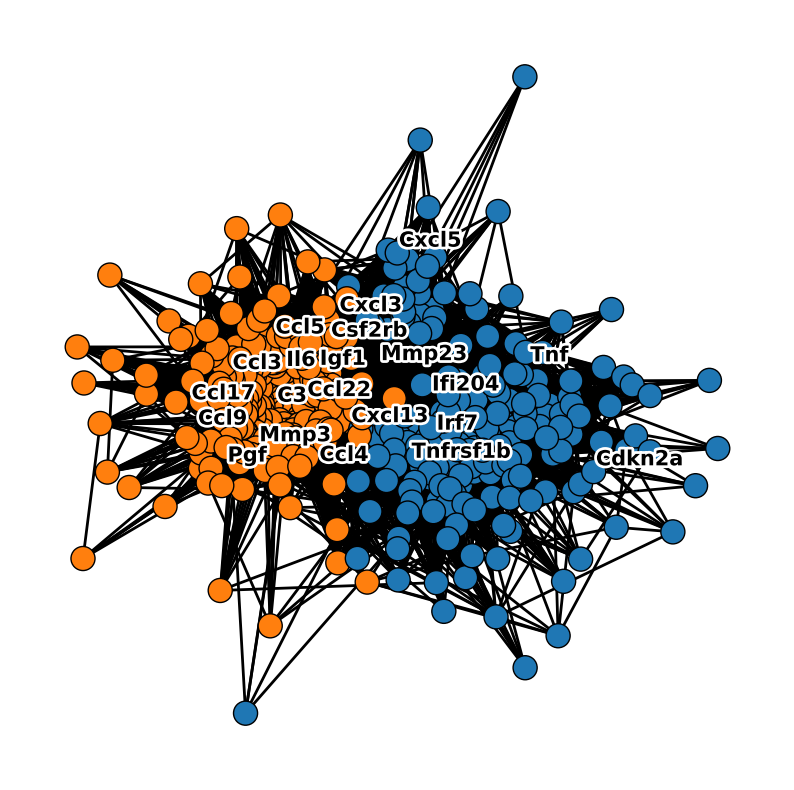

In [89]:
G = nx.Graph()
#G = nx.petersen_graph()



for i, elrow in tester.iterrows():
    G.add_edge(elrow[2], elrow[3], weight=elrow[7])







clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(10,10))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items() if k in markers}


nx.draw_networkx_nodes(G, pos, 
                       node_color = [cc[node] for node in G.nodes()], 
                       edgecolors = 'k')
nx.draw_networkx_edges(G, pos, width =  2)

texts = []
for k in node_lables:
    txt = plt.text(x = node_lables[k][0], y = node_lables[k][1], s = k,
                             fontsize = 15, weight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    texts.append(txt)

adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))



plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)



plt.savefig('figures/R1_3A.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_3A.svg', bbox_inches = 'tight')


plt.show()

## R1
Rev#2 Line 192-193: provide P-value for enrichment

In [90]:
hubs.metadata[hubs.metadata.tissue == 'Tongue']

,tissue,cell,hub_num,size,n_sen,hyp
62,Tongue,basal cell,0,50,1,3.687258e-01
63,Tongue,basal cell,1,266,13,1.091835e-06
64,Tongue,keratinocyte,0,197,5,3.504157e-02
65,Tongue,keratinocyte,1,350,16,1.499907e-07


Rev#2 Line 192: Why pick Tongue keratinocytes? Show overal patterns

In [91]:
hubs.metadata.sort_values('hyp')

,tissue,cell,hub_num,size,n_sen,hyp
16,Heart_and_Aorta,endocardial cell,0,171,17,3.456117e-13
68,Trachea,fibroblast,0,808,27,5.751673e-09
23,Heart_and_Aorta,myocyte,1,95,10,1.655335e-08
47,Lung,fibroblast,1,552,21,3.756258e-08
65,Tongue,keratinocyte,1,350,16,1.499907e-07
...,...,...,...,...,...,...
10,Fat,mesenchymal stem cell,0,38,0,1.000000e+00
7,Diaphragm,skeletal muscle satellite cell,0,60,0,1.000000e+00
1,Bladder,bladder cell,1,20,0,1.000000e+00
55,Myeloid,macrophage,0,77,0,1.000000e+00


In [92]:
def plot_network(ax, G, pos, markers, tissue, cell):


    nx.draw_networkx_nodes(G, pos, 
                           #node_color=[color_d[node] for node in G.nodes()], 
                           node_color=[color_d[(tissue, cell)][node] for node in G.nodes()],
                           edgecolors='k', node_size=15, linewidths = 0.5, ax=ax)
    nx.draw_networkx_edges(G, pos, width=0.25, ax=ax)

    ax.set_aspect('equal')
    #ax.set_xlim(-1.1, 1.1)
    #ax.set_ylim(-1.1, 1.1)
    #ax.axis('off')

    ax.axis('off')

In [93]:

hub_genes = {} #need list of genes in every network
color_d = {} #dict of dicts
hub_colors = {0:'tab:blue', 1 :'tab:orange', 2: 'tab:green', 3: 'tab:purple'}
_ = hubs.metadata.drop_duplicates(['tissue', 'cell'])
for i, row in _.iterrows():
    temp = []
    temp_colors = []
    __ = hubs.metadata[(hubs.metadata.tissue == row.tissue) & (hubs.metadata.cell == row.cell)]
    for ii in range(len(__)):
        the_genes = hubs.get_genes((__.iloc[ii].tissue, __.iloc[ii].cell, __.iloc[ii].hub_num))
        temp += the_genes
        
        #colors
        c = hub_colors[ii]
        temp_colors += [c] * len(the_genes)

    hub_genes[(row.tissue, row.cell)] = temp
    color_d[(row.tissue, row.cell)] = dict(zip(temp, temp_colors))

In [94]:
network_data = []
for i, row in hubs.metadata.iterrows():
    tester = corrs_sig[(corrs_sig.tissue == row.tissue) & (corrs_sig.cell_type_2 == row.cell)].copy()


    
    
    tester['dif'] = tester.r - tester.rnd_r_q99
    tester = tester[(tester.dif > 0.05) & (tester.r > 0.05)].sort_values('dif', ascending = False)
    tester = tester[(tester.gene1.isin(hub_genes[(row.tissue, row.cell)])) & (tester.gene2.isin(hub_genes[(row.tissue, row.cell)]))]
    network_data.append(tester)

In [95]:
networks = {}
for network_df in tqdm(network_data):
    G = nx.Graph()
    for i, elrow in network_df.iterrows():
        G.add_edge(elrow[2], elrow[3], weight=elrow[7])

    #clusters = [list(x) for x in clusters]

    # nodes_to_remove = [node for node in G.nodes() if node not in hub_genes[elrow.tissue, elrow.cell_type_2]]
    # G.remove_nodes_from(nodes_to_remove)
    
    pos = nx.spring_layout(G, seed=1)

    # Add the network and its layout to the list
    #networks[network_df.iloc[0].tissue + '.' + network_df.iloc[0].cell_type_2] = (G, pos, clusters)
    networks[network_df.iloc[0].tissue + '.' + network_df.iloc[0].cell_type_2] = (G, pos)



  0%|                                                    | 0/72 [00:00<?, ?it/s]/tmp/ipykernel_1246317/3605731112.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])
100%|███████████████████████████████████████████| 72/72 [05:25<00:00,  4.52s/it]


In [96]:
import textwrap

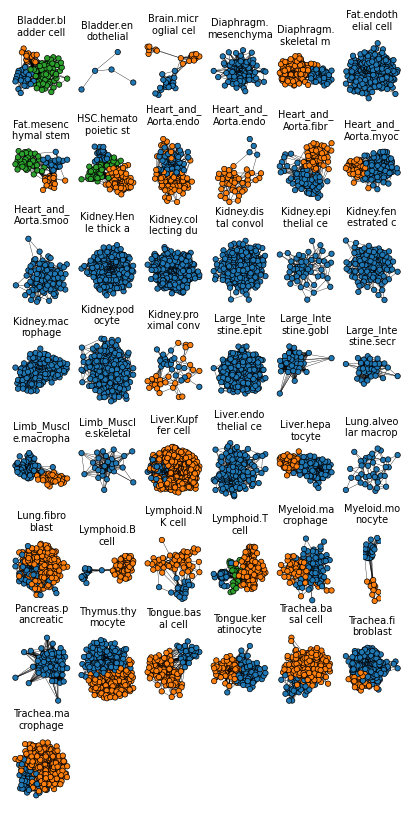

In [99]:
n_networks = len(networks)
num_cols = 6
num_rows = (n_networks + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(4, num_rows * 1))


axes = axes.flatten()


#for i, (G, pos, clusters) in enumerate(networks):
for i, stuff in enumerate(list(networks)):
    #G, pos, clusters = networks[stuff]
    G, pos = networks[stuff]
    #plot_network(axes[i], G, pos, clusters, markers, stuff.split('.')[0], stuff.split('.')[1])
    plot_network(axes[i], G, pos, markers, stuff.split('.')[0], stuff.split('.')[1])

    #axes[i].set_title(str(i), size = 10)
    wrapped_title = "\n".join(textwrap.wrap(stuff[0:20], width=10))  # Adjust width as needed
    axes[i].set_title(wrapped_title, size=7)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad = 0.25)

plt.savefig('figures/all_networks_mouse.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/all_networks_mouse.svg', bbox_inches = 'tight')
plt.show()

In [5]:
import seaborn as sns

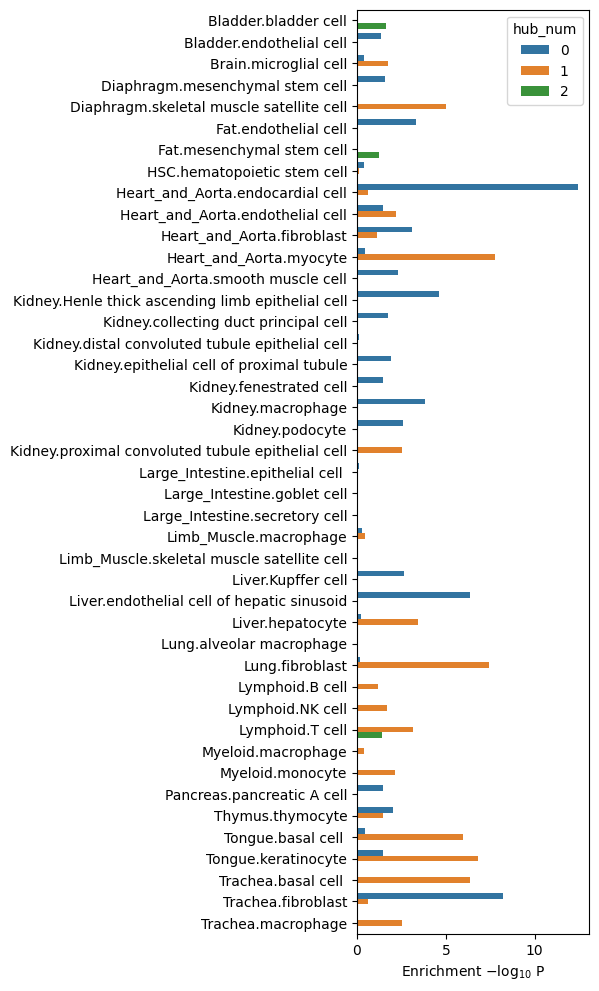

In [102]:
grapher = hubs.metadata.copy()
grapher['label'] = grapher.tissue + '.' + grapher.cell
#grapher['n_sen + 1'] = grapher['n_sen'] + 1
grapher['hub_num'] = grapher.groupby(['tissue', 'cell']).cumcount().astype(str)
grapher.hub_num = grapher.hub_num.astype(str)

grapher['nlogp'] = -np.log10(grapher.hyp)

plt.figure(figsize = (3, 12))

ax = sns.barplot(data = grapher, x = 'nlogp', y = 'label', hue = 'hub_num')

plt.ylabel('')
plt.xlabel(r'Enrichment $-\log_{10} \, \text{P}$')

plt.savefig('figures/all_hubs_mouse_enrichment.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/all_hubs_mouse_enrichment.svg', bbox_inches = 'tight')
plt.show()



In [18]:
grapher[grapher.hyp < 0.05].shape

(36, 8)

In [103]:
#plot dynamics of all hubs

In [104]:
hubs = sp.load_hubs(species='Mouse')

In [105]:
#need to loop over every cell type
cells_to_test = hubs.metadata.groupby(['tissue', 'cell']).size().reset_index()
cells_to_test.head()

,tissue,cell,0
0,Bladder,bladder cell,3
1,Bladder,endothelial cell,1
2,Brain,microglial cell,2
3,Diaphragm,mesenchymal stem cell,1
4,Diaphragm,skeletal muscle satellite cell,2


In [106]:
#ages = ['1m', '3m', '18m', '21', '24m', '30m']
old = ['18m', '21', '24m', '30m']
old = ['21', '24m', '30m']
young = ['1m', '3m']

In [107]:
dfs = []
for i, row in tqdm(cells_to_test.iterrows()):
    sdata = adata[(adata.obs.cell_type_2 == row.cell) &\
    (adata.obs.tissue2 == row.tissue) & (adata.obs.age.isin(old + young))].copy()
    sdata.obs['age_bin'] = sdata.obs.age.map(lambda x: 'old' if x in old else 'young')

    sub_meta = hubs.metadata[(hubs.metadata.tissue == row.tissue) & (hubs.metadata.cell == row.cell)].copy()

    the_obs_names = []
    for ii, sub_row in sub_meta.iterrows():
        the_obs_name = row.tissue + '__' + row.cell + '__' + str(sub_row.hub_num)
        the_obs_names.append(the_obs_name)
        sdata.obs[the_obs_name] = sdata.obsm['sen_outlier'][the_obs_name]*1

    a_df = sdata.obs[['age_bin'] + the_obs_names].groupby('age_bin',observed = False).sum()
    a_df['Count'] = sdata.obs.groupby('age_bin',observed = False).count().loc[a_df.index].batch

    new_cols_to_add = ['hub 0', 'hub 1', 'hub 2', 'hub 3'] #renaming for consistent colors in plot
    new_cols_to_add = new_cols_to_add[:len(the_obs_names)]

    for y, col in enumerate(new_cols_to_add):
        a_df[col] = a_df[the_obs_names[y]] /a_df.Count * 100

    a_df['age_bin'] = a_df.index
    a_df = a_df.melt(id_vars = 'age_bin', value_vars=new_cols_to_add)
    a_df['tissue_cell'] = row.tissue + '.' + row.cell
        
    dfs.append(a_df)

43it [00:14,  3.07it/s]


In [112]:
df = pd.concat(dfs)

In [113]:
df

,age_bin,variable,value,tissue_cell
0,old,hub 0,2.481752,Bladder.bladder cell
1,young,hub 0,0.039777,Bladder.bladder cell
2,old,hub 1,2.481752,Bladder.bladder cell
3,young,hub 1,0.159109,Bladder.bladder cell
4,old,hub 2,12.992701,Bladder.bladder cell
...,...,...,...,...
3,old,hub 1,7.500000,Trachea.fibroblast
0,young,hub 0,0.202429,Trachea.macrophage
1,old,hub 0,10.638298,Trachea.macrophage
2,young,hub 1,0.000000,Trachea.macrophage


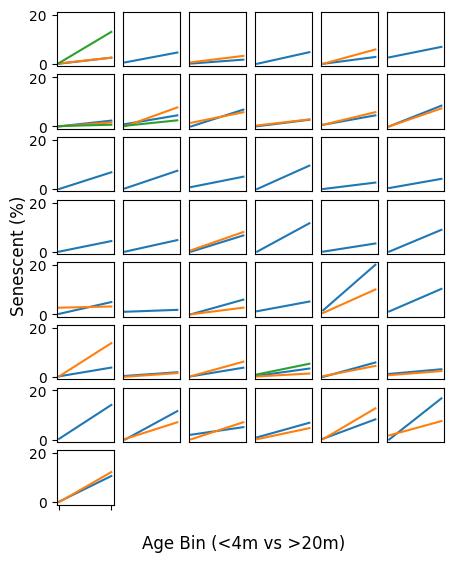

In [114]:
n_networks = len(networks)
num_cols = 6
num_rows = (n_networks + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, num_rows * .8),  sharex=True, sharey=True)


axes = axes.flatten()


#for i, (G, pos, clusters) in enumerate(networks):
for i, cell in enumerate(df.tissue_cell.unique()):
    ax = axes[i]
    sub = df[df.tissue_cell == cell]
    sub = sub.sort_values(['age_bin', 'variable'], ascending = [False, True])
    
    sns.lineplot(data=sub, x='age_bin', y='value', hue = 'variable', ax=ax)
    #ax.set_title(f'Tissue Cell: {cell}')
    ax.legend().remove()
    ax.set_ylabel('')
    ax.set_xlabel('')

    if i % num_cols != 0:  # Not in the first column
        ax.tick_params(left=False, labelleft=False)
    if i < len(axes) - num_cols:  # Not in the last row
        ax.tick_params(bottom=False, labelbottom=False)
        
    ax.set_xticklabels([])



for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.05, 0.5, 'Senescent (%)', ha='center', va='center', fontsize=12,  rotation=90)
fig.text(0.5, 0.05, 'Age Bin (<4m vs >20m)', ha='center', va='center', fontsize=12,)


plt.subplots_adjust(wspace=.15, hspace=.15)
#plt.tight_layout()

plt.savefig('figures/all_hubs_trends.png', dpi = 600, transparent=True, bbox_inches = 'tight')
plt.savefig('figures/all_hubs_trends.svg', transparent=True, bbox_inches = 'tight')

plt.show()

In [115]:
graphy = df.copy()

In [116]:
graphy['tch'] = graphy.tissue_cell + graphy.variable

In [117]:
graphy = graphy.sort_values(['age_bin'], ascending = False)

In [118]:
#Wilcoxon signed-rank test
s, p = stats.wilcoxon(graphy[graphy.age_bin == 'old'].sort_values('tch').value.tolist(),
               graphy[graphy.age_bin == 'young'].sort_values('tch').value.tolist(),
               alternative='greater')

In [119]:
print(s, p)

2628.0 8.293759011881989e-14


/tmp/ipykernel_1246317/3055432354.py:4: UserWarning: 
The palette list has fewer values (1) than needed (72) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(data = graphy, x = 'age_bin', y = 'value', hue = 'tch', palette = ['k'], alpha = 0.5)
/tmp/ipykernel_1246317/3055432354.py:5: UserWarning: 
The palette list has fewer values (1) than needed (72) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data = graphy, x = 'age_bin', y = 'value', hue = 'tch', palette = ['k'])


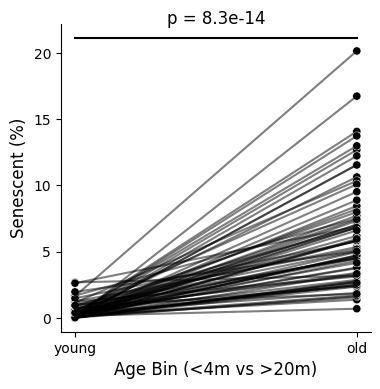

In [120]:
plt.figure(figsize = (4,4))


ax = sns.lineplot(data = graphy, x = 'age_bin', y = 'value', hue = 'tch', palette = ['k'], alpha = 0.5)
ax = sns.scatterplot(data = graphy, x = 'age_bin', y = 'value', hue = 'tch', palette = ['k'])

plt.legend([],[], frameon=False)

plt.ylabel('Senescent (%)', fontsize = 12)

plt.xlabel('Age Bin (<4m vs >20m)', fontsize = 12)


x_coords = ['young', 'old']
y_coord = max(graphy['value']) + 1  # Adjust the y-coordinate as needed for your data
plt.plot(x_coords, [y_coord, y_coord], color='black', lw=1.5)


plt.text(0.5, 1, f'p = {p:.1e}', fontsize=12, ha='center', transform=ax.transAxes)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.savefig('figures/all_hubs_test.png', dpi = 600, transparent=True, bbox_inches = 'tight')
plt.savefig('figures/all_hubs_test.svg', transparent=True, bbox_inches = 'tight')

plt.show()

# REMOVE BELOW. NOT USED

In [ ]:
#with 18m

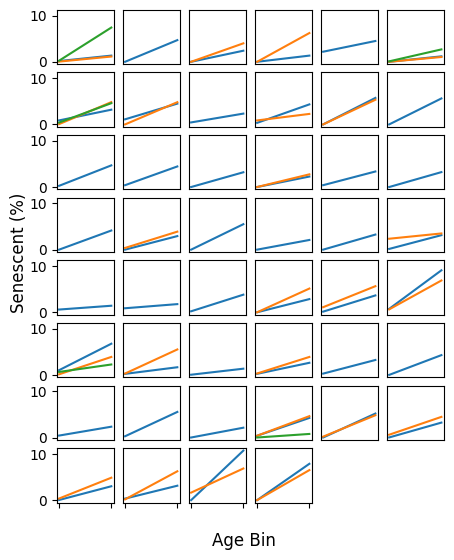

In [92]:
n_networks = len(networks)
num_cols = 6
num_rows = (n_networks + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, num_rows * .8),  sharex=True, sharey=True)


axes = axes.flatten()


#for i, (G, pos, clusters) in enumerate(networks):
for i, cell in enumerate(df.tissue_cell.unique()):
    ax = axes[i]
    sub = df[df.tissue_cell == cell]
    sub = sub.sort_values(['age_bin', 'variable'], ascending = [False, True])
    
    sns.lineplot(data=sub, x='age_bin', y='value', hue = 'variable', ax=ax)
    #ax.set_title(f'Tissue Cell: {cell}')
    ax.legend().remove()
    ax.set_ylabel('')
    ax.set_xlabel('')

    if i % num_cols != 0:  # Not in the first column
        ax.tick_params(left=False, labelleft=False)
    if i < len(axes) - num_cols:  # Not in the last row
        ax.tick_params(bottom=False, labelbottom=False)
        
    ax.set_xticklabels([])



for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.05, 0.5, 'Senescent (%)', ha='center', va='center', fontsize=12,  rotation=90)
fig.text(0.5, 0.05, 'Age Bin (<4m, >17m)', ha='center', va='center', fontsize=12,  )


plt.subplots_adjust(wspace=.15, hspace=.15)
#plt.tight_layout()

plt.savefig('figures/all_hubs_trends.png', dpi = 600, transparent=True, bbox_inches = 'tight')
plt.savefig('figures/all_hubs_trends.svg', transparent=True, bbox_inches = 'tight')

plt.show()

In [ ]:
dfs = []
for i, row in tqdm(cells_to_test.iterrows()):
    sdata = adata[(adata.obs.cell_type_2 == row.cell) &\
    (adata.obs.tissue2 == row.tissue)].copy()
    #loop every hub and add in obs column
    sub_meta = hubs.metadata[(hubs.metadata.tissue == row.tissue) & (hubs.metadata.cell == row.cell)].copy()
    sub_meta['hub_num_color'] = range(len(sub_meta)) #not sure if i will need this or not...
    the_obs_names = []
    for ii, sub_row in sub_meta.iterrows():
        the_obs_name = row.tissue + '__' + row.cell + '__' + str(sub_row.hub_num)
        the_obs_names.append(the_obs_name)
        sdata.obs[the_obs_name] = sdata.obsm['sen_outlier'][the_obs_name]*1

    a_df = sdata.obs[['age'] + the_obs_names].groupby('age',observed = False).sum()
    #sdata.obs.groupby('age').count().batch #make sure index in same order
    a_df['Count'] = sdata.obs.groupby('age',observed = False).count().batch #make sure index in same order


    new_cols_to_add = ['hub 0', 'hub 1', 'hub 2', 'hub 3'] #renaming for consistent colors in plot
    new_cols_to_add = new_cols_to_add[:len(the_obs_names)]

    for y, col in enumerate(new_cols_to_add):
        a_df[col] = a_df[the_obs_names[y]] /a_df.Count * 100

    a_df['age'] = a_df.index

    a_df = a_df.melt(id_vars = 'age', value_vars=new_cols_to_add)
    a_df.age = a_df.age.map(lambda x: int(x.replace('m', ''))).astype('int')
    a_df['tissue_cell'] = row.tissue + '.' + row.cell
    
    dfs.append(a_df)

In [405]:
dfs = []
for i, row in tqdm(cells_to_test.iterrows()):
    sdata = adata[(adata.obs.cell_type_2 == row.cell) &\
    (adata.obs.tissue2 == row.tissue)].copy()
    #loop every hub and add in obs column
    sub_meta = hubs.metadata[(hubs.metadata.tissue == row.tissue) & (hubs.metadata.cell == row.cell)].copy()
    sub_meta['hub_num_color'] = range(len(sub_meta)) #not sure if i will need this or not...
    the_obs_names = []
    for ii, sub_row in sub_meta.iterrows():
        the_obs_name = row.tissue + '__' + row.cell + '__' + str(sub_row.hub_num)
        the_obs_names.append(the_obs_name)
        sdata.obs[the_obs_name] = sdata.obsm['sen_outlier'][the_obs_name]*1

    a_df = sdata.obs[['age'] + the_obs_names].groupby('age',observed = False).sum()
    #sdata.obs.groupby('age').count().batch #make sure index in same order
    a_df['Count'] = sdata.obs.groupby('age',observed = False).count().batch #make sure index in same order


    new_cols_to_add = ['hub 0', 'hub 1', 'hub 2', 'hub 3'] #renaming for consistent colors in plot
    new_cols_to_add = new_cols_to_add[:len(the_obs_names)]

    for y, col in enumerate(new_cols_to_add):
        a_df[col] = a_df[the_obs_names[y]] /a_df.Count * 100

    a_df['age'] = a_df.index

    a_df = a_df.melt(id_vars = 'age', value_vars=new_cols_to_add)
    a_df.age = a_df.age.map(lambda x: int(x.replace('m', ''))).astype('int')
    a_df['tissue_cell'] = row.tissue + '.' + row.cell
    
    dfs.append(a_df)

46it [00:01, 26.36it/s]


In [406]:
df = pd.concat(dfs)

In [407]:
df[df.tissue_cell == 'Fat.mesenchymal stem cell']

,age,variable,value,tissue_cell
0,3,hub 0,0.000000,Fat.mesenchymal stem cell
1,18,hub 0,0.000000,Fat.mesenchymal stem cell
2,21,hub 0,0.396825,Fat.mesenchymal stem cell
3,24,hub 0,1.356744,Fat.mesenchymal stem cell
4,30,hub 0,5.007587,Fat.mesenchymal stem cell
5,3,hub 1,0.000000,Fat.mesenchymal stem cell
6,18,hub 1,0.552486,Fat.mesenchymal stem cell
7,21,hub 1,0.793651,Fat.mesenchymal stem cell
8,24,hub 1,0.079808,Fat.mesenchymal stem cell
9,30,hub 1,4.552352,Fat.mesenchymal stem cell


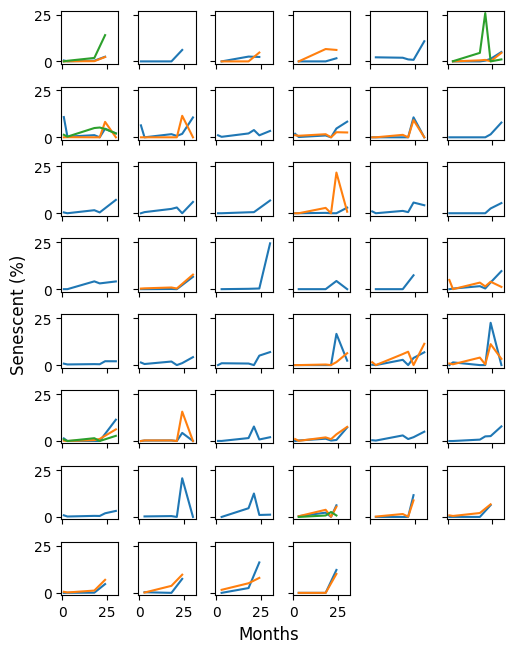

In [423]:
n_networks = len(networks)
num_cols = 6
num_rows = (n_networks + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, num_rows * .8),  sharex=True, sharey=True)


axes = axes.flatten()


#for i, (G, pos, clusters) in enumerate(networks):
for i, cell in enumerate(df.tissue_cell.unique()):
    ax = axes[i]
    sns.lineplot(data=df[df.tissue_cell == cell], x='age', y='value', hue = 'variable', ax=ax)
    #ax.set_title(f'Tissue Cell: {cell}')
    ax.legend().remove()
    ax.set_ylabel('')
    ax.set_xlabel('')




for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0, 0.5, 'Senescent (%)', ha='center', va='center', fontsize=12,  rotation=90)
fig.text(0.5, 0, 'Months', ha='center', va='center', fontsize=12,  )



plt.tight_layout()

plt.savefig('figures/all_hubs_trends.png', dpi = 600, transparent=True, bbox_inches = 'tight')
plt.savefig('figures/all_hubs_trends.svg', transparent=True, bbox_inches = 'tight')

plt.show()